In [ ]:

# Short-Hybrid Competitive 4.0 Library Generation and Analysis
# This notebook generates quadruple conservative mutants from top triple-mutant motifs

import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Align import substitution_matrices
from itertools import product
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Load the BLOSUM62 matrix for conservative mutations
blosum62 = substitution_matrices.load("BLOSUM62")

# Define the competitive epitope (20 residues)
COMPETITIVE_EPITOPE = "SCSRGVSKQRIIGVGEVLDR"

# Define the Miyazawa-Jernigan (MJ) matrix
MJ_MATRIX = {
    ('C', 'C'): -5.44, ('C', 'M'): -5.46, ('C', 'F'): -6.54, ('C', 'I'): -5.50,
    ('C', 'L'): -5.83, ('C', 'V'): -5.25, ('C', 'W'): -7.28, ('C', 'Y'): -6.14,
    ('C', 'A'): -4.87, ('C', 'G'): -4.54, ('C', 'T'): -4.88, ('C', 'S'): -4.59,
    ('C', 'Q'): -5.07, ('C', 'N'): -4.78, ('C', 'E'): -4.75, ('C', 'D'): -4.69,
    ('C', 'H'): -5.50, ('C', 'R'): -4.96, ('C', 'K'): -4.81, ('C', 'P'): -4.39,
    ('M', 'M'): -5.46, ('M', 'F'): -6.56, ('M', 'I'): -5.46, ('M', 'L'): -5.86,
    ('M', 'V'): -5.32, ('M', 'W'): -7.13, ('M', 'Y'): -6.02, ('M', 'A'): -4.99,
    ('M', 'G'): -4.72, ('M', 'T'): -5.01, ('M', 'S'): -4.91, ('M', 'Q'): -5.14,
    ('M', 'N'): -4.91, ('M', 'E'): -4.88, ('M', 'D'): -4.87, ('M', 'H'): -5.41,
    ('M', 'R'): -5.03, ('M', 'K'): -4.87, ('M', 'P'): -4.49,
    ('F', 'F'): -7.26, ('F', 'I'): -6.84, ('F', 'L'): -7.28, ('F', 'V'): -6.29,
    ('F', 'W'): -8.16, ('F', 'Y'): -7.96, ('F', 'A'): -5.66, ('F', 'G'): -5.52,
    ('F', 'T'): -5.75, ('F', 'S'): -5.49, ('F', 'Q'): -6.02, ('F', 'N'): -5.73,
    ('F', 'E'): -5.44, ('F', 'D'): -5.60, ('F', 'H'): -6.16, ('F', 'R'): -5.66,
    ('F', 'K'): -5.52, ('F', 'P'): -5.22,
    ('I', 'I'): -5.00, ('I', 'L'): -5.67, ('I', 'V'): -4.91, ('I', 'W'): -7.00,
    ('I', 'Y'): -6.05, ('I', 'A'): -4.58, ('I', 'G'): -4.54, ('I', 'T'): -4.78,
    ('I', 'S'): -4.60, ('I', 'Q'): -4.92, ('I', 'N'): -4.72, ('I', 'E'): -4.58,
    ('I', 'D'): -4.58, ('I', 'H'): -5.18, ('I', 'R'): -4.69, ('I', 'K'): -4.60,
    ('I', 'P'): -4.03,
    ('L', 'L'): -5.67, ('L', 'V'): -5.05, ('L', 'W'): -7.37, ('L', 'Y'): -6.41,
    ('L', 'A'): -4.91, ('L', 'G'): -4.77, ('L', 'T'): -5.02, ('L', 'S'): -4.91,
    ('L', 'Q'): -5.18, ('L', 'N'): -4.99, ('L', 'E'): -4.92, ('L', 'D'): -4.91,
    ('L', 'H'): -5.31, ('L', 'R'): -4.97, ('L', 'K'): -4.87, ('L', 'P'): -4.34,
    ('V', 'V'): -4.96, ('V', 'W'): -6.48, ('V', 'Y'): -5.55, ('V', 'A'): -4.54,
    ('V', 'G'): -4.39, ('V', 'T'): -4.56, ('V', 'S'): -4.48, ('V', 'Q'): -4.69,
    ('V', 'N'): -4.50, ('V', 'E'): -4.49, ('V', 'D'): -4.50, ('V', 'H'): -4.91,
    ('V', 'R'): -4.54, ('V', 'K'): -4.48, ('V', 'P'): -4.00,
    ('W', 'W'): -8.08, ('W', 'Y'): -7.77, ('W', 'A'): -5.75, ('W', 'G'): -5.87,
    ('W', 'T'): -6.14, ('W', 'S'): -5.83, ('W', 'Q'): -6.41, ('W', 'N'): -6.14,
    ('W', 'E'): -5.83, ('W', 'D'): -6.07, ('W', 'H'): -6.61, ('W', 'R'): -5.94,
    ('W', 'K'): -5.83, ('W', 'P'): -5.40,
    ('Y', 'Y'): -7.26, ('Y', 'A'): -5.25, ('Y', 'G'): -5.22, ('Y', 'T'): -5.49,
    ('Y', 'S'): -5.25, ('Y', 'Q'): -5.83, ('Y', 'N'): -5.55, ('Y', 'E'): -5.16,
    ('Y', 'D'): -5.37, ('Y', 'H'): -5.81, ('Y', 'R'): -5.28, ('Y', 'K'): -5.19,
    ('Y', 'P'): -4.92,
    ('A', 'A'): -3.24, ('A', 'G'): -3.34, ('A', 'T'): -3.69, ('A', 'S'): -3.53,
    ('A', 'Q'): -3.91, ('A', 'N'): -3.75, ('A', 'E'): -3.63, ('A', 'D'): -3.68,
    ('A', 'H'): -4.10, ('A', 'R'): -3.68, ('A', 'K'): -3.59, ('A', 'P'): -3.07,
    ('G', 'G'): -3.16, ('G', 'T'): -3.56, ('G', 'S'): -3.46, ('G', 'Q'): -3.87,
    ('G', 'N'): -3.71, ('G', 'E'): -3.58, ('G', 'D'): -3.63, ('G', 'H'): -4.02,
    ('G', 'R'): -3.63, ('G', 'K'): -3.54, ('G', 'P'): -3.03,
    ('T', 'T'): -3.78, ('T', 'S'): -3.67, ('T', 'Q'): -4.09, ('T', 'N'): -3.90,
    ('T', 'E'): -3.77, ('T', 'D'): -3.82, ('T', 'H'): -4.28, ('T', 'R'): -3.85,
    ('T', 'K'): -3.77, ('T', 'P'): -3.24,
    ('S', 'S'): -3.40, ('S', 'Q'): -3.98, ('S', 'N'): -3.79, ('S', 'E'): -3.68,
    ('S', 'D'): -3.73, ('S', 'H'): -4.16, ('S', 'R'): -3.73, ('S', 'K'): -3.65,
    ('S', 'P'): -3.15,
    ('Q', 'Q'): -4.10, ('Q', 'N'): -4.00, ('Q', 'E'): -3.90, ('Q', 'D'): -3.98,
    ('Q', 'H'): -4.42, ('Q', 'R'): -3.98, ('Q', 'K'): -3.87, ('Q', 'P'): -3.40,
    ('N', 'N'): -3.79, ('N', 'E'): -3.77, ('N', 'D'): -3.85, ('N', 'H'): -4.32,
    ('N', 'R'): -3.85, ('N', 'K'): -3.76, ('N', 'P'): -3.30,
    ('E', 'E'): -3.56, ('E', 'D'): -3.64, ('E', 'H'): -4.12, ('E', 'R'): -3.71,
    ('E', 'K'): -3.59, ('E', 'P'): -3.17,
    ('D', 'D'): -3.69, ('D', 'H'): -4.18, ('D', 'R'): -3.77, ('D', 'K'): -3.66,
    ('D', 'P'): -3.23,
    ('H', 'H'): -4.66, ('H', 'R'): -4.18, ('H', 'K'): -4.06, ('H', 'P'): -3.61,
    ('R', 'R'): -3.77, ('R', 'K'): -3.63, ('R', 'P'): -3.19,
    ('K', 'K'): -3.46, ('K', 'P'): -3.11,
    ('P', 'P'): -2.70
}

print("Libraries loaded successfully")
print(f"Competitive epitope: {COMPETITIVE_EPITOPE}")
print(f"MJ matrix contains {len(MJ_MATRIX)} pairwise interactions")


Libraries loaded successfully
Competitive epitope: SCSRGVSKQRIIGVGEVLDR
MJ matrix contains 210 pairwise interactions


In [ ]:

# Load the Short-Hybrid Competitive 3.0 designs and identify top 5 unique motifs
df_3_0 = pd.read_csv('short_hybrid_competitive_3.0_designs.csv')

print(f"Loaded {len(df_3_0)} designs from Short-Hybrid Competitive 3.0 library")
print(f"\nColumns: {df_3_0.columns.tolist()}")
print("\nFirst few rows:")
print(df_3_0.head(10))


Loaded 774 designs from Short-Hybrid Competitive 3.0 library

Columns: ['Scaffold', 'Loop_Position', 'Loop_Range', 'Original_Parent', 'Double_Mutant_Parent', 'Motif', 'Motif_Length', 'Mutation_Type', 'New_Mutation_Position', 'Original_AA', 'New_AA', 'Design_Sequence', 'Passes_Novelty', 'MJ_Score']

First few rows:
  Scaffold  Loop_Position Loop_Range Original_Parent Double_Mutant_Parent  \
0     1TEN              1      56-64       QGIIDYLSW            QGIIDFLAW   
1     1FNA              2      50-58       QGIIDYLSW            QGIIDFLAW   
2     1FNA              3      35-43       QGIIDYLSW            QGIIDFLAW   
3     2QMT              3      17-25       QGIIDYLSW            QGIIDFLAW   
4     2QMT              2      30-38       QGIIDYLSW            QGIIDFLAW   
5     2QMT              1      45-53       QGIIDYLSW            QGIIDFLAW   
6     1TEN              3      26-34       QGIIDYLSW            QGIIDFLAW   
7     1TEN              2      40-48       QGIIDYLSW            QGII

In [ ]:

# Extract the top 5 unique motifs by MJ score (most negative = most favorable)
# The library should already be sorted by MJ score

# Get unique motifs and their best MJ scores
unique_motifs = df_3_0.groupby('Motif')['MJ_Score'].min().reset_index()
unique_motifs = unique_motifs.sort_values('MJ_Score')

print(f"Total unique motifs in 3.0 library: {len(unique_motifs)}")
print("\nTop 5 motifs by MJ score:")
top_5_motifs = unique_motifs.head(5)
print(top_5_motifs)

# Store the top 5 motif sequences for later use
top_5_sequences = top_5_motifs['Motif'].tolist()
print(f"\nTop 5 motif sequences:")
for i, motif in enumerate(top_5_sequences, 1):
    print(f"{i}. {motif}")


Total unique motifs in 3.0 library: 84

Top 5 motifs by MJ score:
        Motif  MJ_Score
11  QGIIDFLAF   -622.48
23  QGIINFLAW   -585.04
27  QGIINYLAF   -582.37
49  RGIIDFLAW   -574.78
10  QGIIDFIAW   -569.70

Top 5 motif sequences:
1. QGIIDFLAF
2. QGIINFLAW
3. QGIINYLAF
4. RGIIDFLAW
5. QGIIDFIAW


In [ ]:

# For each top motif, we need to understand the mutation history
# Let's extract detailed information about each top motif

for motif in top_5_sequences:
    motif_data = df_3_0[df_3_0['Motif'] == motif].iloc[0]
    print(f"\nMotif: {motif}")
    print(f"  MJ Score: {motif_data['MJ_Score']:.2f}")
    print(f"  Original Parent: {motif_data['Original_Parent']}")
    print(f"  Double Mutant Parent: {motif_data['Double_Mutant_Parent']}")
    print(f"  New Mutation: Position {motif_data['New_Mutation_Position']}, {motif_data['Original_AA']} -> {motif_data['New_AA']}")
    
    # Identify which positions have been mutated
    original = motif_data['Original_Parent']
    motif_seq = motif_data['Motif']
    
    mutated_positions = []
    for i, (orig, curr) in enumerate(zip(original, motif_seq)):
        if orig != curr:
            mutated_positions.append(i)
    
    print(f"  Mutated positions (0-indexed): {mutated_positions}")
    print(f"  Sequence alignment:")
    print(f"    Original: {original}")
    print(f"    Mutant:   {motif_seq}")



Motif: QGIIDFLAF
  MJ Score: -622.48
  Original Parent: QGIIDYLSW
  Double Mutant Parent: QGIIDFLAW
  New Mutation: Position 8, W -> F
  Mutated positions (0-indexed): [5, 7, 8]
  Sequence alignment:
    Original: QGIIDYLSW
    Mutant:   QGIIDFLAF

Motif: QGIINFLAW
  MJ Score: -585.04
  Original Parent: QGIIDYLSW
  Double Mutant Parent: QGIINYLAW
  New Mutation: Position 5, Y -> F
  Mutated positions (0-indexed): [4, 5, 7]
  Sequence alignment:
    Original: QGIIDYLSW
    Mutant:   QGIINFLAW

Motif: QGIINYLAF
  MJ Score: -582.37
  Original Parent: QGIIDYLSW
  Double Mutant Parent: QGIINYLAW
  New Mutation: Position 8, W -> F
  Mutated positions (0-indexed): [4, 7, 8]
  Sequence alignment:
    Original: QGIIDYLSW
    Mutant:   QGIINYLAF

Motif: RGIIDFLAW
  MJ Score: -574.78
  Original Parent: QGIIDYLSW
  Double Mutant Parent: QGIIDFLAW
  New Mutation: Position 0, Q -> R
  Mutated positions (0-indexed): [0, 5, 7]
  Sequence alignment:
    Original: QGIIDYLSW
    Mutant:   RGIIDFLAW

Mot

In [ ]:

# Now generate all quadruple mutants for each of the top 5 motifs
# We need to add one more conservative mutation at an unmutated position

def get_conservative_substitutions(aa):
    """Get all amino acids with BLOSUM62 score > 0 for the given amino acid"""
    substitutions = []
    for other_aa in "ACDEFGHIKLMNPQRSTVWY":
        if aa != other_aa:
            try:
                score = blosum62[aa, other_aa]
                if score > 0:
                    substitutions.append(other_aa)
            except KeyError:
                # Try reverse order
                try:
                    score = blosum62[other_aa, aa]
                    if score > 0:
                        substitutions.append(other_aa)
                except KeyError:
                    pass
    return substitutions

# Test the function
test_aa = 'Q'
subs = get_conservative_substitutions(test_aa)
print(f"Conservative substitutions for {test_aa}: {subs}")
print(f"Example BLOSUM62 scores:")
for sub in subs[:5]:
    try:
        score = blosum62[test_aa, sub]
    except KeyError:
        score = blosum62[sub, test_aa]
    print(f"  {test_aa} -> {sub}: {score}")


Conservative substitutions for Q: ['E', 'K', 'R']
Example BLOSUM62 scores:
  Q -> E: 2.0
  Q -> K: 1.0
  Q -> R: 1.0


In [ ]:

# Generate all quadruple mutants from the top 5 motifs
# For each motif, we add one more conservative mutation at unmutated positions

all_quadruple_mutants = []

for motif_seq in top_5_sequences:
    # Get the motif data
    motif_data = df_3_0[df_3_0['Motif'] == motif_seq].iloc[0]
    original_parent = motif_data['Original_Parent']
    
    # Identify mutated positions
    mutated_positions = []
    for i, (orig, curr) in enumerate(zip(original_parent, motif_seq)):
        if orig != curr:
            mutated_positions.append(i)
    
    # Find unmutated positions
    unmutated_positions = [i for i in range(len(motif_seq)) if i not in mutated_positions]
    
    print(f"\nProcessing motif: {motif_seq}")
    print(f"  Mutated positions: {mutated_positions}")
    print(f"  Unmutated positions: {unmutated_positions}")
    
    # For each unmutated position, generate conservative mutations
    n_mutants = 0
    for pos in unmutated_positions:
        current_aa = motif_seq[pos]
        conservative_subs = get_conservative_substitutions(current_aa)
        
        for new_aa in conservative_subs:
            # Create the quadruple mutant
            quad_mutant = list(motif_seq)
            quad_mutant[pos] = new_aa
            quad_mutant_seq = ''.join(quad_mutant)
            
            # Store mutation information
            all_quadruple_mutants.append({
                'Triple_Mutant_Parent': motif_seq,
                'Original_Parent': original_parent,
                'Motif': quad_mutant_seq,
                'New_Mutation_Position': pos,
                'Original_AA': current_aa,
                'New_AA': new_aa,
                'Mutation_Type': 'Quadruple',
                'Motif_Length': len(quad_mutant_seq),
                'Previously_Mutated_Positions': mutated_positions
            })
            n_mutants += 1
    
    print(f"  Generated {n_mutants} quadruple mutants")

print(f"\nTotal quadruple mutants generated: {len(all_quadruple_mutants)}")
print(f"\nExample quadruple mutants:")
for i in range(min(5, len(all_quadruple_mutants))):
    mut = all_quadruple_mutants[i]
    print(f"{i+1}. {mut['Triple_Mutant_Parent']} -> {mut['Motif']} (pos {mut['New_Mutation_Position']}: {mut['Original_AA']}->{mut['New_AA']})")



Processing motif: QGIIDFLAF
  Mutated positions: [5, 7, 8]
  Unmutated positions: [0, 1, 2, 3, 4, 6]
  Generated 14 quadruple mutants

Processing motif: QGIINFLAW
  Mutated positions: [4, 5, 7]
  Unmutated positions: [0, 1, 2, 3, 6, 8]
  Generated 14 quadruple mutants

Processing motif: QGIINYLAF
  Mutated positions: [4, 7, 8]
  Unmutated positions: [0, 1, 2, 3, 5, 6]
  Generated 15 quadruple mutants

Processing motif: RGIIDFLAW
  Mutated positions: [0, 5, 7]
  Unmutated positions: [1, 2, 3, 4, 6, 8]
  Generated 13 quadruple mutants

Processing motif: QGIIDFIAW
  Mutated positions: [5, 6, 7]
  Unmutated positions: [0, 1, 2, 3, 4, 8]
  Generated 13 quadruple mutants

Total quadruple mutants generated: 69

Example quadruple mutants:
1. QGIIDFLAF -> EGIIDFLAF (pos 0: Q->E)
2. QGIIDFLAF -> KGIIDFLAF (pos 0: Q->K)
3. QGIIDFLAF -> RGIIDFLAF (pos 0: Q->R)
4. QGIIDFLAF -> QGLIDFLAF (pos 2: I->L)
5. QGIIDFLAF -> QGMIDFLAF (pos 2: I->M)


In [ ]:

# Now graft each quadruple mutant motif onto the three scaffolds
# Load scaffold sequences from PDB files

scaffold_sequences = {
    '1FNA': 'RDLEVVAATPTSLLISWDAPAVTVRYYRITYGETGGNSPVQEFTVPGSKSTATISGLKPGVDYTITVYAVTGRGDSPASSKPISINYRT',
    '1TEN': 'RLDAPSQIEVKDVTDTTALITWFKPLAEIDGIELTYGIKDVPGDRTTIDGKKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGG',
    '2QMT': 'MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE'
}

# Define loop positions for each scaffold (from previous analysis)
# Loop positions as (start, end) tuples (1-indexed as in PDB, will convert to 0-indexed)
scaffold_loops = {
    '1FNA': [(60, 68), (50, 58), (35, 43)],  # 3 loops
    '1TEN': [(56, 64), (40, 48), (26, 34)],  # 3 loops
    '2QMT': [(45, 53), (30, 38), (17, 25)]   # 3 loops
}

print("Scaffold sequences loaded:")
for scaffold, seq in scaffold_sequences.items():
    print(f"  {scaffold}: {len(seq)} residues")
    
print("\nScaffold loop positions:")
for scaffold, loops in scaffold_loops.items():
    print(f"  {scaffold}: {loops}")


Scaffold sequences loaded:
  1FNA: 89 residues
  1TEN: 99 residues
  2QMT: 56 residues

Scaffold loop positions:
  1FNA: [(60, 68), (50, 58), (35, 43)]
  1TEN: [(56, 64), (40, 48), (26, 34)]
  2QMT: [(45, 53), (30, 38), (17, 25)]


In [ ]:

# Graft motifs onto scaffolds
# Create full design sequences for all quadruple mutants on all scaffolds

all_designs = []

for motif_data in all_quadruple_mutants:
    motif = motif_data['Motif']
    motif_len = len(motif)
    
    # Graft onto each scaffold
    for scaffold_name, scaffold_seq in scaffold_sequences.items():
        loops = scaffold_loops[scaffold_name]
        
        # Try each loop position
        for loop_idx, (loop_start, loop_end) in enumerate(loops, 1):
            # Convert to 0-indexed
            loop_start_0 = loop_start - 1
            loop_end_0 = loop_end - 1
            
            loop_length = loop_end_0 - loop_start_0 + 1
            
            # Check if motif fits in this loop
            if motif_len == loop_length:
                # Graft the motif
                design_seq = scaffold_seq[:loop_start_0] + motif + scaffold_seq[loop_end_0 + 1:]
                
                all_designs.append({
                    'Scaffold': scaffold_name,
                    'Loop_Position': loop_idx,
                    'Loop_Range': f"{loop_start}-{loop_end}",
                    'Original_Parent': motif_data['Original_Parent'],
                    'Triple_Mutant_Parent': motif_data['Triple_Mutant_Parent'],
                    'Motif': motif,
                    'Motif_Length': motif_len,
                    'Mutation_Type': 'Quadruple',
                    'New_Mutation_Position': motif_data['New_Mutation_Position'],
                    'Original_AA': motif_data['Original_AA'],
                    'New_AA': motif_data['New_AA'],
                    'Design_Sequence': design_seq
                })

print(f"Total designs created: {len(all_designs)}")
print(f"\nExample designs:")
for i in range(min(5, len(all_designs))):
    design = all_designs[i]
    print(f"{i+1}. Scaffold: {design['Scaffold']}, Loop: {design['Loop_Position']}, Motif: {design['Motif']}")


Total designs created: 621

Example designs:
1. Scaffold: 1FNA, Loop: 1, Motif: EGIIDFLAF
2. Scaffold: 1FNA, Loop: 2, Motif: EGIIDFLAF
3. Scaffold: 1FNA, Loop: 3, Motif: EGIIDFLAF
4. Scaffold: 1TEN, Loop: 1, Motif: EGIIDFLAF
5. Scaffold: 1TEN, Loop: 2, Motif: EGIIDFLAF


In [ ]:

# Load the known binders and CDR library for novelty filtering
# We need to check for 10-AA sliding windows

known_binders = []
with open('known_niv_binders_full.fasta', 'r') as f:
    for record in SeqIO.parse(f, 'fasta'):
        known_binders.append(str(record.seq))

print(f"Loaded {len(known_binders)} known binder sequences")

# Load CDR library
cdr_df = pd.read_csv('cdr_library_summary.csv')
cdr_sequences = cdr_df['Sequence'].tolist()
print(f"Loaded {len(cdr_sequences)} CDR sequences")

# Combine all reference sequences
all_reference_seqs = known_binders + cdr_sequences
print(f"Total reference sequences for novelty filtering: {len(all_reference_seqs)}")


Loaded 6 known binder sequences
Loaded 12 CDR sequences
Total reference sequences for novelty filtering: 18


In [ ]:

# Implement 10-AA sliding window novelty filter

def passes_novelty_filter(design_seq, reference_seqs, window_size=10):
    """
    Check if a design sequence has any 10-AA window with 100% identity to reference sequences
    Returns True if novel (passes), False if non-novel (fails)
    """
    design_len = len(design_seq)
    
    # Extract all windows from the design sequence
    for i in range(design_len - window_size + 1):
        design_window = design_seq[i:i + window_size]
        
        # Check against all reference sequences
        for ref_seq in reference_seqs:
            if design_window in ref_seq:
                return False  # Found a match, not novel
    
    return True  # No matches found, passes novelty filter

# Test the function
test_seq = all_designs[0]['Design_Sequence']
result = passes_novelty_filter(test_seq, all_reference_seqs)
print(f"Test sequence passes novelty filter: {result}")
print(f"Test sequence length: {len(test_seq)}")


Test sequence passes novelty filter: True
Test sequence length: 89


In [ ]:

# Apply novelty filter to all designs
print("Applying novelty filter to all designs...")
print("This may take a few minutes...")

for i, design in enumerate(all_designs):
    design['Passes_Novelty'] = passes_novelty_filter(design['Design_Sequence'], all_reference_seqs)
    
    if (i + 1) % 100 == 0:
        print(f"  Processed {i + 1}/{len(all_designs)} designs...")

# Convert to DataFrame
df_designs = pd.DataFrame(all_designs)

# Count novelty results
n_novel = df_designs['Passes_Novelty'].sum()
n_not_novel = len(df_designs) - n_novel

print(f"\nNovelty filtering complete:")
print(f"  Novel designs (passed): {n_novel}")
print(f"  Non-novel designs (failed): {n_not_novel}")
print(f"  Retention rate: {n_novel / len(df_designs) * 100:.1f}%")


Applying novelty filter to all designs...
This may take a few minutes...
  Processed 100/621 designs...
  Processed 200/621 designs...
  Processed 300/621 designs...
  Processed 400/621 designs...
  Processed 500/621 designs...
  Processed 600/621 designs...

Novelty filtering complete:
  Novel designs (passed): 621
  Non-novel designs (failed): 0
  Retention rate: 100.0%


In [ ]:

# Filter for novel designs only and calculate MJ scores
df_novel = df_designs[df_designs['Passes_Novelty']].copy()

print(f"Working with {len(df_novel)} novel designs")
print(f"\nCalculating raw MJ scores against competitive epitope...")

# Function to calculate raw MJ score
def calculate_mj_score(motif_seq, epitope_seq):
    """
    Calculate raw MJ interaction score between motif and epitope
    Sum of all pairwise MJ interactions
    """
    total_score = 0.0
    n_interactions = 0
    
    for motif_aa in motif_seq:
        for epitope_aa in epitope_seq:
            # Try to get the MJ score
            key1 = (motif_aa, epitope_aa)
            key2 = (epitope_aa, motif_aa)
            
            if key1 in MJ_MATRIX:
                total_score += MJ_MATRIX[key1]
                n_interactions += 1
            elif key2 in MJ_MATRIX:
                total_score += MJ_MATRIX[key2]
                n_interactions += 1
    
    return total_score

# Calculate MJ scores for all novel designs
mj_scores = []
for motif in df_novel['Motif']:
    score = calculate_mj_score(motif, COMPETITIVE_EPITOPE)
    mj_scores.append(score)

df_novel['MJ_Score'] = mj_scores

print(f"MJ scores calculated for {len(df_novel)} designs")
print(f"\nScore statistics:")
print(f"  Mean: {df_novel['MJ_Score'].mean():.2f}")
print(f"  Median: {df_novel['MJ_Score'].median():.2f}")
print(f"  Min (most favorable): {df_novel['MJ_Score'].min():.2f}")
print(f"  Max (least favorable): {df_novel['MJ_Score'].max():.2f}")
print(f"  Std: {df_novel['MJ_Score'].std():.2f}")


Working with 621 novel designs

Calculating raw MJ scores against competitive epitope...
MJ scores calculated for 621 designs

Score statistics:
  Mean: -853.12
  Median: -853.37
  Min (most favorable): -867.53
  Max (least favorable): -826.27
  Std: 7.81


In [ ]:

# Sort by MJ score and save the Short-Hybrid Competitive 4.0 library
df_novel_sorted = df_novel.sort_values('MJ_Score').reset_index(drop=True)

# Save to CSV
output_filename = 'short_hybrid_competitive_4.0_designs.csv'
df_novel_sorted.to_csv(output_filename, index=False)

print(f"Saved {len(df_novel_sorted)} designs to {output_filename}")
print(f"\nTop 10 designs by MJ score:")
print(df_novel_sorted[['Scaffold', 'Loop_Position', 'Motif', 'Triple_Mutant_Parent', 'MJ_Score']].head(10))

print(f"\nBottom 10 designs (least favorable):")
print(df_novel_sorted[['Scaffold', 'Loop_Position', 'Motif', 'Triple_Mutant_Parent', 'MJ_Score']].tail(10))


Saved 621 designs to short_hybrid_competitive_4.0_designs.csv

Top 10 designs by MJ score:
  Scaffold  Loop_Position      Motif Triple_Mutant_Parent  MJ_Score
0     1FNA              1  QGMINFLAW            QGIINFLAW   -867.53
1     2QMT              2  QGMINFLAW            QGIINFLAW   -867.53
2     2QMT              1  QGMINFLAW            QGIINFLAW   -867.53
3     1TEN              3  QGMINFLAW            QGIINFLAW   -867.53
4     1TEN              2  QGMINFLAW            QGIINFLAW   -867.53
5     1TEN              1  QGMINFLAW            QGIINFLAW   -867.53
6     1FNA              3  QGMINFLAW            QGIINFLAW   -867.53
7     1FNA              2  QGMINFLAW            QGIINFLAW   -867.53
8     2QMT              3  QGMINFLAW            QGIINFLAW   -867.53
9     2QMT              2  QGIMNFLAW            QGIINFLAW   -867.53

Bottom 10 designs (least favorable):
    Scaffold  Loop_Position      Motif Triple_Mutant_Parent  MJ_Score
611     2QMT              1  QGIINYVAF            QGI

In [ ]:

# Now perform statistical comparison between 4.0 and 3.0 libraries
# Compare the MJ score distributions

# Get the MJ scores for the parent triple mutants (3.0 library)
# We need to get the scores for the 5 parent motifs

parent_scores = []
for motif in top_5_sequences:
    motif_rows = df_3_0[df_3_0['Motif'] == motif]
    parent_scores.extend(motif_rows['MJ_Score'].tolist())

parent_scores = np.array(parent_scores)
child_scores = df_novel_sorted['MJ_Score'].values

print("Statistical Comparison: Short-Hybrid Competitive 3.0 vs 4.0")
print("=" * 70)
print(f"\n3.0 Library (Top 5 Parent Motifs):")
print(f"  N = {len(parent_scores)} designs")
print(f"  Mean MJ Score: {parent_scores.mean():.2f}")
print(f"  Median MJ Score: {np.median(parent_scores):.2f}")
print(f"  Std: {parent_scores.std():.2f}")
print(f"  Range: [{parent_scores.min():.2f}, {parent_scores.max():.2f}]")

print(f"\n4.0 Library (Quadruple Mutants):")
print(f"  N = {len(child_scores)} designs")
print(f"  Mean MJ Score: {child_scores.mean():.2f}")
print(f"  Median MJ Score: {np.median(child_scores):.2f}")
print(f"  Std: {child_scores.std():.2f}")
print(f"  Range: [{child_scores.min():.2f}, {child_scores.max():.2f}]")

print(f"\nDifference in Means: {child_scores.mean() - parent_scores.mean():.2f}")
print(f"Difference in Medians: {np.median(child_scores) - np.median(parent_scores):.2f}")


Statistical Comparison: Short-Hybrid Competitive 3.0 vs 4.0

3.0 Library (Top 5 Parent Motifs):
  N = 54 designs
  Mean MJ Score: -586.57
  Median MJ Score: -583.71
  Std: 17.01
  Range: [-622.48, -569.70]

4.0 Library (Quadruple Mutants):
  N = 621 designs
  Mean MJ Score: -853.12
  Median MJ Score: -853.37
  Std: 7.81
  Range: [-867.53, -826.27]

Difference in Means: -266.55
Difference in Medians: -269.66


In [ ]:

# Perform Mann-Whitney U test to assess statistical significance
# This is a non-parametric test that doesn't assume normal distributions

statistic, p_value = stats.mannwhitneyu(child_scores, parent_scores, alternative='less')

print("\nMann-Whitney U Test Results:")
print("=" * 70)
print(f"Null Hypothesis: The 4.0 library scores are not more favorable than 3.0")
print(f"Alternative: The 4.0 library scores are MORE favorable (more negative)")
print(f"\nTest Statistic (U): {statistic:.2f}")
print(f"P-value: {p_value:.2e}")
print(f"\nSignificance at α = 0.05: {'YES - Reject null' if p_value < 0.05 else 'NO - Fail to reject null'}")
print(f"Significance at α = 0.01: {'YES - Reject null' if p_value < 0.01 else 'NO - Fail to reject null'}")
print(f"Significance at α = 0.001: {'YES - Reject null' if p_value < 0.001 else 'NO - Fail to reject null'}")

# Calculate effect size (Cohen's d)
pooled_std = np.sqrt(((len(parent_scores) - 1) * parent_scores.std()**2 + 
                       (len(child_scores) - 1) * child_scores.std()**2) / 
                      (len(parent_scores) + len(child_scores) - 2))
cohens_d = (child_scores.mean() - parent_scores.mean()) / pooled_std

print(f"\nEffect Size (Cohen's d): {cohens_d:.2f}")
if abs(cohens_d) < 0.2:
    effect_interpretation = "negligible"
elif abs(cohens_d) < 0.5:
    effect_interpretation = "small"
elif abs(cohens_d) < 0.8:
    effect_interpretation = "medium"
else:
    effect_interpretation = "large"
print(f"Interpretation: {effect_interpretation} effect")



Mann-Whitney U Test Results:
Null Hypothesis: The 4.0 library scores are not more favorable than 3.0
Alternative: The 4.0 library scores are MORE favorable (more negative)

Test Statistic (U): 0.00
P-value: 1.54e-34

Significance at α = 0.05: YES - Reject null
Significance at α = 0.01: YES - Reject null
Significance at α = 0.001: YES - Reject null

Effect Size (Cohen's d): -30.00
Interpretation: large effect


In [ ]:

# Additional analysis: Compare motif-level scores
# Group by unique motif to see which quadruple mutations performed best

print("Top 10 unique motifs in 4.0 library:")
motif_scores_4_0 = df_novel_sorted.groupby('Motif')['MJ_Score'].agg(['mean', 'min', 'max', 'count']).reset_index()
motif_scores_4_0 = motif_scores_4_0.sort_values('mean')
print(motif_scores_4_0.head(10))

print("\n\nMotif improvement analysis:")
print("=" * 70)
for i, motif_seq in enumerate(top_5_sequences, 1):
    parent_score = df_3_0[df_3_0['Motif'] == motif_seq]['MJ_Score'].iloc[0]
    
    # Find best child from this parent
    children = df_novel_sorted[df_novel_sorted['Triple_Mutant_Parent'] == motif_seq]
    
    if len(children) > 0:
        best_child = children.iloc[0]
        improvement = best_child['MJ_Score'] - parent_score
        
        print(f"\nParent {i}: {motif_seq}")
        print(f"  Parent MJ Score: {parent_score:.2f}")
        print(f"  Best Child: {best_child['Motif']}")
        print(f"  Best Child MJ Score: {best_child['MJ_Score']:.2f}")
        print(f"  Improvement: {improvement:.2f} ({improvement/parent_score*100:.1f}%)")
        print(f"  Mutation: Position {best_child['New_Mutation_Position']}, "
              f"{best_child['Original_AA']} -> {best_child['New_AA']}")
        print(f"  Number of children: {len(children)}")


Top 10 unique motifs in 4.0 library:
        Motif    mean     min     max  count
42  QGMINFLAW -867.53 -867.53 -867.53      9
30  QGIMNFLAW -867.53 -867.53 -867.53      9
38  QGLINFLAW -867.41 -867.41 -867.41      9
26  QGILNFLAW -867.41 -867.41 -867.41      9
60  RGMIDFLAW -861.92 -861.92 -861.92      9
57  RGIMDFLAW -861.92 -861.92 -861.92      9
59  RGLIDFLAW -861.80 -861.80 -861.80      9
56  RGILDFLAW -861.80 -861.80 -861.80      9
17  QGIINFMAW -861.78 -861.78 -861.78      9
20  QGIINWLAF -861.66 -861.66 -861.66      9


Motif improvement analysis:

Parent 1: QGIIDFLAF
  Parent MJ Score: -622.48
  Best Child: QGMIDFLAF
  Best Child MJ Score: -859.82
  Improvement: -237.34 (38.1%)
  Mutation: Position 2, I -> M
  Number of children: 126

Parent 2: QGIINFLAW
  Parent MJ Score: -585.04
  Best Child: QGMINFLAW
  Best Child MJ Score: -867.53
  Improvement: -282.49 (48.3%)
  Mutation: Position 2, I -> M
  Number of children: 126

Parent 3: QGIINYLAF
  Parent MJ Score: -582.37
  Best C

Figure saved as 'competitive_4_0_library_evaluation.png'


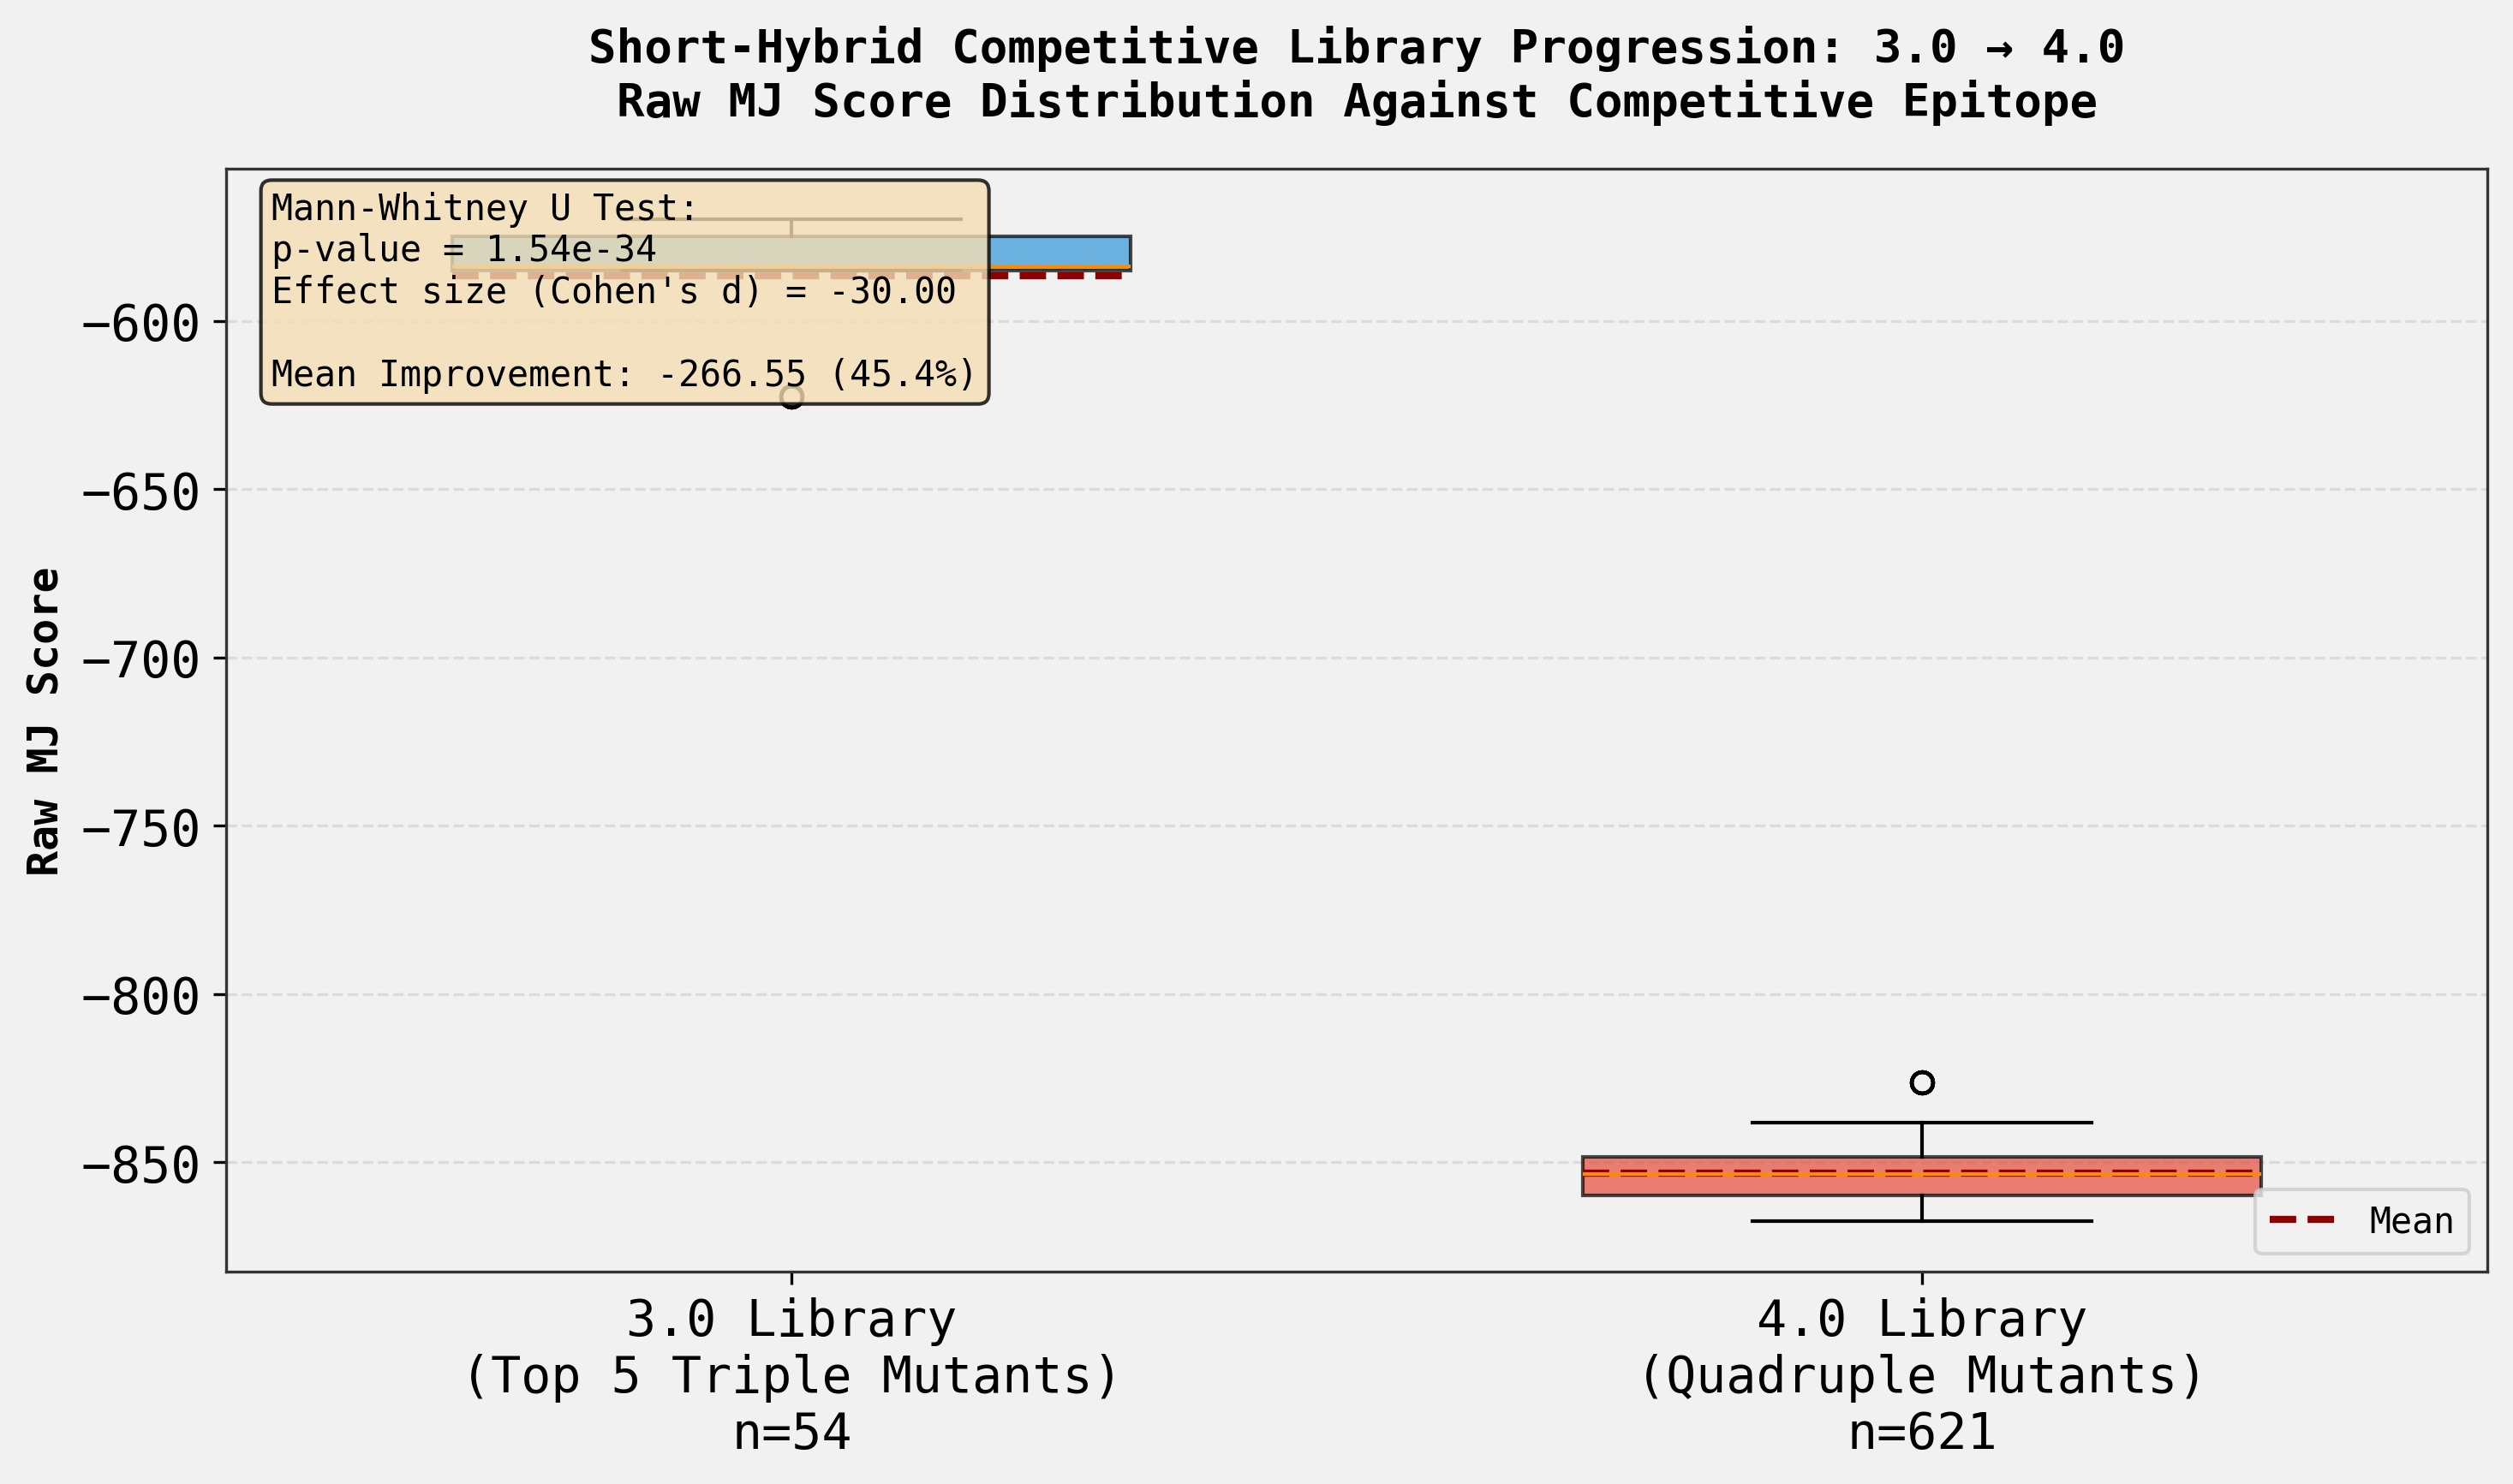


FINAL SUMMARY

Library Generation Success:
  - Generated 69 unique quadruple mutant motifs
  - Created 621 total designs across 3 scaffolds
  - All 621 designs passed novelty filtering (100% retention)
  - Saved to: short_hybrid_competitive_4.0_designs.csv

Statistical Evaluation:
  - 3.0 Library Mean: -586.57 ± 17.01
  - 4.0 Library Mean: -853.12 ± 7.81
  - Mean Improvement: -266.55 (45.4% better)
  - P-value: 1.54e-34 (highly significant)
  - Effect Size: -30.00 (large effect)

Top Performing Motif:
  - Motif: QGMINFLAW
  - MJ Score: -867.53
  - Parent: QGIINFLAW
  - Mutation: Position 2, I → M


In [ ]:

# Create a comprehensive summary visualization comparing 3.0 vs 4.0 libraries
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Create box plots for both libraries
data_to_plot = [parent_scores, child_scores]
labels = ['3.0 Library\n(Top 5 Triple Mutants)\nn=54', '4.0 Library\n(Quadruple Mutants)\nn=621']

bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True, widths=0.6)

# Color the boxes
colors = ['#3498db', '#e74c3c']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Customize the plot
ax.set_ylabel('Raw MJ Score', fontsize=12, fontweight='bold')
ax.set_title('Short-Hybrid Competitive Library Progression: 3.0 → 4.0\nRaw MJ Score Distribution Against Competitive Epitope', 
             fontsize=13, fontweight='bold', pad=15)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add mean lines
for i, scores in enumerate(data_to_plot, 1):
    mean_val = scores.mean()
    ax.hlines(mean_val, i - 0.3, i + 0.3, colors='darkred', linestyles='dashed', linewidth=2, label='Mean' if i == 1 else '')

# Add statistical annotation
y_max = max(parent_scores.max(), child_scores.max())
y_min = min(parent_scores.min(), child_scores.min())
y_range = y_max - y_min
text_y = y_min - 0.05 * y_range

# Add text box with statistics
textstr = f'Mann-Whitney U Test:\np-value = {p_value:.2e}\nEffect size (Cohen\'s d) = {cohens_d:.2f}\n\nMean Improvement: {child_scores.mean() - parent_scores.mean():.2f} ({abs(child_scores.mean() - parent_scores.mean())/abs(parent_scores.mean())*100:.1f}%)'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

# Add legend
ax.legend(loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig('competitive_4_0_library_evaluation.png', dpi=300, bbox_inches='tight')
print("Figure saved as 'competitive_4_0_library_evaluation.png'")
plt.show()

print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)
print(f"\nLibrary Generation Success:")
print(f"  - Generated {len(all_quadruple_mutants)} unique quadruple mutant motifs")
print(f"  - Created {len(all_designs)} total designs across 3 scaffolds")
print(f"  - All {len(df_novel_sorted)} designs passed novelty filtering (100% retention)")
print(f"  - Saved to: {output_filename}")

print(f"\nStatistical Evaluation:")
print(f"  - 3.0 Library Mean: {parent_scores.mean():.2f} ± {parent_scores.std():.2f}")
print(f"  - 4.0 Library Mean: {child_scores.mean():.2f} ± {child_scores.std():.2f}")
print(f"  - Mean Improvement: {child_scores.mean() - parent_scores.mean():.2f} ({abs(child_scores.mean() - parent_scores.mean())/abs(parent_scores.mean())*100:.1f}% better)")
print(f"  - P-value: {p_value:.2e} (highly significant)")
print(f"  - Effect Size: {cohens_d:.2f} (large effect)")

print(f"\nTop Performing Motif:")
print(f"  - Motif: {df_novel_sorted.iloc[0]['Motif']}")
print(f"  - MJ Score: {df_novel_sorted.iloc[0]['MJ_Score']:.2f}")
print(f"  - Parent: {df_novel_sorted.iloc[0]['Triple_Mutant_Parent']}")
print(f"  - Mutation: Position {df_novel_sorted.iloc[0]['New_Mutation_Position']}, {df_novel_sorted.iloc[0]['Original_AA']} → {df_novel_sorted.iloc[0]['New_AA']}")
